In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
import zipfile
import random
import shutil
from tensorflow.keras.optimizers import RMSprop
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook

import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from scipy.spatial.distance import cosine, euclidean
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import plot_model
!pip install livelossplot
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import os
from PIL import Image
import cv2
from collections import Counter
!pip install imutils
from imutils import *
from scipy.spatial.distance import cosine, euclidean
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
!pip install plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly as ply
from sklearn.metrics import *
ply.offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

init_notebook_mode(connected=True)
RANDOM_SEED = 123

print("All modules have been imported")
IMG_PATH = '/content/drive/MyDrive/Tumor detection/brain_tumor_dataset/'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


All modules have been imported


In [5]:
#already created train/test/val split
#loading the data
def load_data(dir_path, img_size=(100,100)):

    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


#confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [6]:
TRAIN_DIR = IMG_PATH+'training/'
TEST_DIR = IMG_PATH+'test/'
VAL_DIR = IMG_PATH+'val/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

  0%|          | 0/2 [00:00<?, ?it/s]

193 images loaded from /content/drive/MyDrive/Tumor detection/brain_tumor_dataset/training/ directory.


  0%|          | 0/2 [00:00<?, ?it/s]

10 images loaded from /content/drive/MyDrive/Tumor detection/brain_tumor_dataset/test/ directory.


100%|██████████| 2/2 [00:11<00:00,  5.98s/it]

50 images loaded from /content/drive/MyDrive/Tumor detection/brain_tumor_dataset/val/ directory.


In [7]:
X_train.shape

(193,)

In [8]:
#plotting the images 
def plot_samples(X, y, labels_dict, n=50):

    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])
            # print(img.shape)
            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

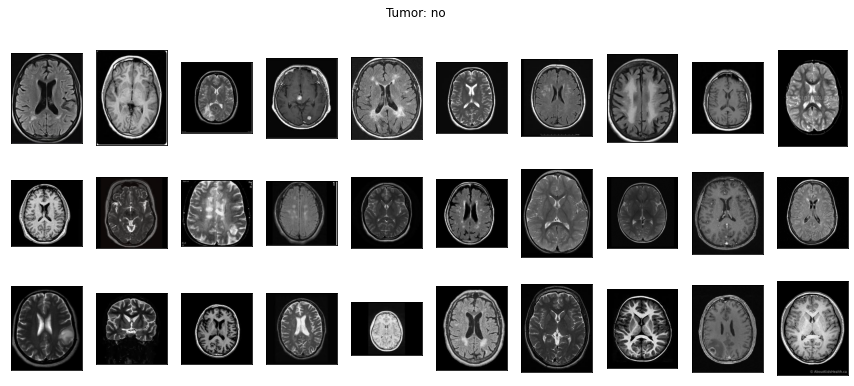

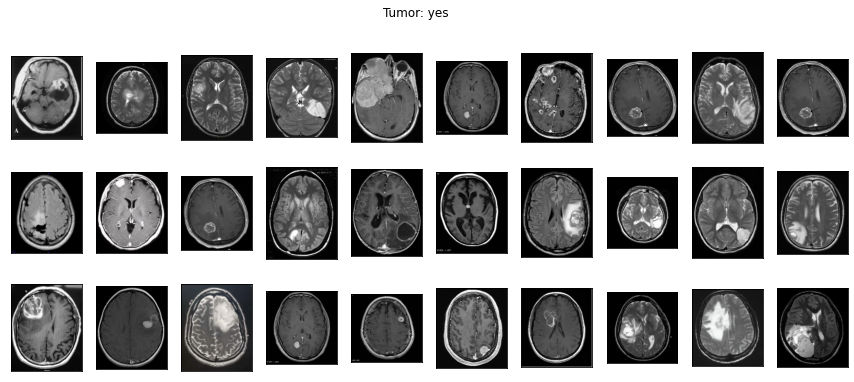

In [9]:

plot_samples(X_train, y_train, labels, 30)

In [10]:
X_train.shape

(193,)

In [11]:
#finding the distribution of classes in the sets
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
y = {}
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

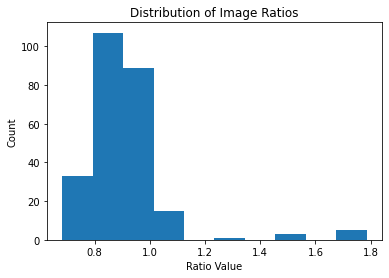

In [12]:
#finding the ratioh of height/width of images 
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [13]:
import itertools
import imutils
#different images have different width and height 
#normalization finding the extreme points of the brain
def crop_imgs(set_name, add_pixels_value=0):

    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

In [14]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

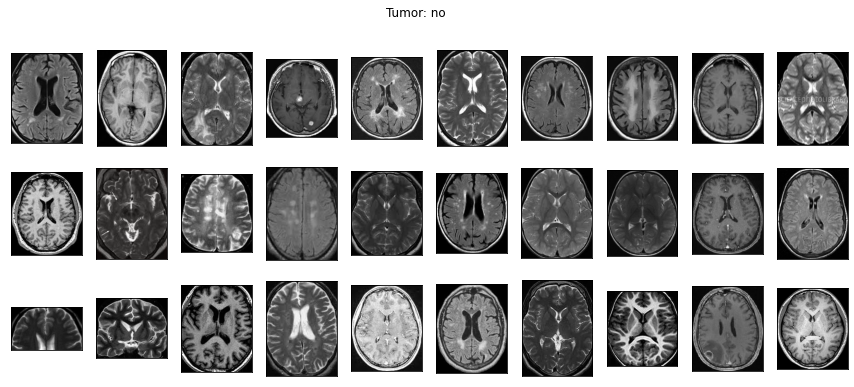

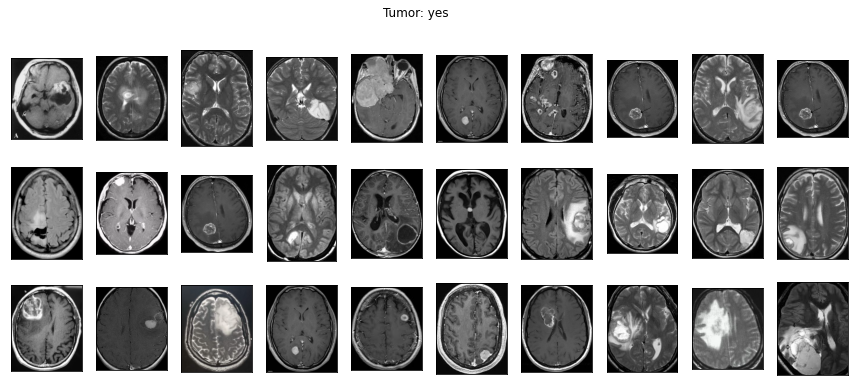

In [15]:
plot_samples(X_train_crop, y_train, labels, 30)

In [16]:
#already saved the new images in train,test,val/crop
from keras.applications.vgg16 import VGG16, preprocess_input
def preprocess_imgs(set_name, img_size):

    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [17]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [18]:
RANDOM_SEED = 5
IMG_PATH = '/content/drive/MyDrive/Tumor detection/brain_tumor_dataset/'
TRAIN_DIR = IMG_PATH+'train_crop/'
VAL_DIR = IMG_PATH+'val_crop/'

train_datagen = ImageDataGenerator(

    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


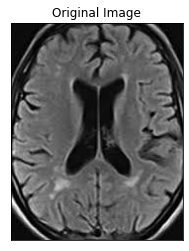

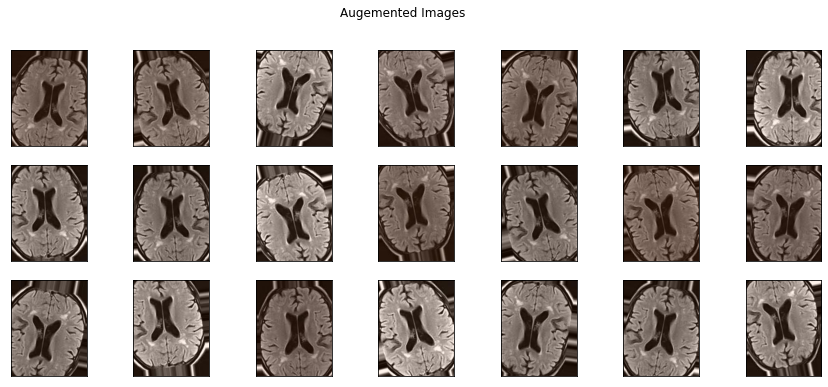

In [19]:

#checking whether the augmented images 
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in train_datagen.flow(x, batch_size=1, save_to_dir=IMG_PATH+'preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir(IMG_PATH+'preview/'):
    img = cv2.cv2.imread(IMG_PATH+'preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

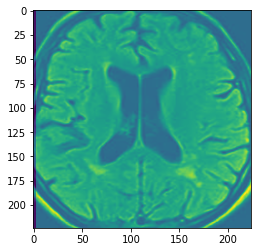

In [20]:
plt.imshow(X_train_prep[0])

In [21]:
IMG_SHAPE = (224,224,1)
def euclidean_distance(vectors):
    #unpacking the vectors in different lists
    feat_a, feat_b = vectors 
    #compute the sum of squared distances between the vectors 
    sum_squared = K.sum(K.square(feat_a-feat_b), axis=1, keepdims=True)

    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [22]:
def make_pairs(images, labels):
    #initialize list to store(image,image)
    pair_images = []
    pair_labels = []
    #initialize list to store correlation if the pair is positive or negative 
    num_classes = len(np.unique(labels))
    idx = [np.where(labels==i)[0] for i in range(0,2)]

    #loop over all images 
    for idxa in range(len(images)):
        # grab the current image and label belonging to the current iteration
        current_image = images[idxa]
        label = labels[idxa]

        #randomly pick an image that belongs to the same class
        idxb = np.random.choice(idx[label])
        pos_image = images[idxb]

        #prepare a positive pair and update the images and the labels lists respectively 

        pair_images.append([current_image, pos_image])
        pair_labels.append([1])

        #find the labels of the images that is not equal to the current label and randomly find correspoding to the label
        neg_idx = np.where(labels!=label)[0]

        neg_image = images[np.random.choice(neg_idx)]

        #prepare a negative pair
        pair_images.append([current_image, neg_image])
        pair_labels.append([0])

    return (np.array(pair_images), np.array(pair_labels))

		

In [23]:
def load_data(img_location, name):
    imgs = []
    labels = []
    for img in os.listdir(os.path.join(img_location, name)):
        img_arr = cv2.imread(os.path.join(img_location, name, img))
        img_arr = cv2.resize(img_arr, (IMG_SHAPE[1], IMG_SHAPE[0]))
        labels.append(name)
        imgs.append(img_arr)
    
    return imgs, labels  

In [24]:
train_pairs, train_pair_labels = make_pairs(X_train_prep, y_train)
val_pairs, val_pair_labels = make_pairs(X_val_prep, y_val)

In [25]:
print(f"train_pairs shape : {train_pairs.shape}")
print(f"val_pairs shape : {val_pairs.shape}")
print(f"train_pair_labels shape : {train_pair_labels.shape}")
print(f"val_pair_labels shape : {val_pair_labels.shape}")

train_pairs shape : (386, 2, 224, 224)
val_pairs shape : (100, 2, 224, 224)
train_pair_labels shape : (386, 1)
val_pair_labels shape : (100, 1)


In [26]:
#building a siamese model
def siamese_model(input_shape, embedding_dim=24):
    inputs = Input(input_shape)
    #specify inputs for the feature extractor network

    #define the first set of conv=> RELU => pool => dropout layer
    l = Conv2D(256, (4,4), padding="same", activation="relu")(inputs)
    l = BatchNormalization()(l)
    l = MaxPooling2D(pool_size=(2,2))(l)
    l = Dropout(0.3)(l)

    #define the second set of conv=> RELU => pool => dropout layer
    l = Conv2D(128, (7,7), padding="same", activation="relu")(inputs)
    l = BatchNormalization()(l)
    l = MaxPooling2D(pool_size=(2,2))(l)
    l = Dropout(0.3)(l)

    #define the third set of conv=> RELU => pool => dropout layer
    l = Conv2D(128, (10,10), padding="same", activation="relu")(inputs)
    l = BatchNormalization()(l)
    l = MaxPooling2D(pool_size=(2,2))(l)
    l = Dropout(0.3)(l)

    #define the fourth set of conv=> RELU => pool => dropout layer
    # l = Conv2D(256, (4,4), padding="same", activation="relu")(inputs)
    # l = BatchNormalization()(l)
    # l = MaxPooling2D(pool_size=(2,2))(l)
    # l = Dropout(0.3)(l)



    #prepare final output 
    pooled_output = GlobalAveragePooling2D()(l)
    outputs = Dense(embedding_dim, name="Embedding")(pooled_output)

    #build the model
    model = Model(inputs, outputs)

    return model


In [27]:
# L2 Distance
emb_size=24
# def triplet_loss(alpha, emb_dim):
#     def loss(y_true, y_pred):
#         anc, pos, neg = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
#         distance1 = tf.sqrt(tf.reduce_sum(tf.pow(anc - pos, 2), 1, keepdims=True))
#         distance2 = tf.sqrt(tf.reduce_sum(tf.pow(anc - neg, 2), 1, keepdims=True))
#         return tf.reduce_mean(tf.maximum(distance1 - distance2 + alpha, 0.))
#     return loss

In [28]:
# Cosine Similarity
def triplet_loss(alpha, emb_dim):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
        distance1 = tf.keras.losses.cosine_similarity(anc, pos)
        distance2 = tf.keras.losses.cosine_similarity(anc, neg)
        return tf.keras.backend.clip(distance1 - distance2 + alpha, 0., None)
    return loss

In [29]:
#configure the siamese network 
img_a = Input(shape = IMG_SHAPE)
img_b = Input(shape = IMG_SHAPE)
feature_extractor = siamese_model(IMG_SHAPE, 128)
feats_a = feature_extractor(img_a)
feats_b = feature_extractor(img_b)

#construct the siamese network
distance = Lambda(euclidean_distance, name="Euclidean_distance")([feats_a, feats_b])
outputs = Dense(1, activation="sigmoid", name="similarity")(distance)
model = Model(inputs=[img_a, img_b], outputs=outputs, name="SiameseNetwork")

In [40]:
model.compile(loss=triplet_loss(alpha=0.1, emb_dim=36), optimizer="adam", metrics=["accuracy"])

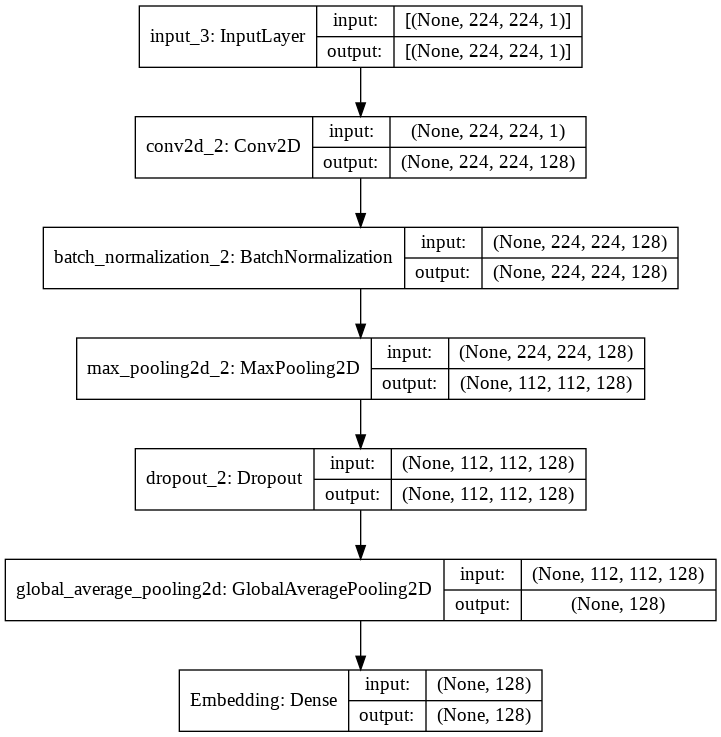

In [41]:
plot_model(feature_extractor, to_file='featureExtractor.png', show_shapes=True, show_layer_names=True)

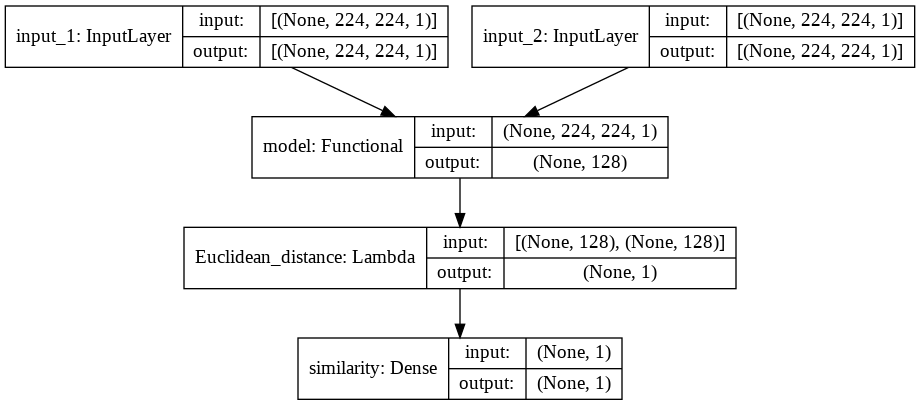

In [42]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [43]:
print(train_pairs[:, 0].shape)
print(train_pair_labels[:].shape)

(386, 224, 224)
(386, 1)


In [44]:
x_train = np.array([train_pairs[:, 0], train_pairs[:, 1]])
y_train = train_pair_labels[:]
x_val = np.array([val_pairs[:, 0], val_pairs[:, 1]])
y_val = val_pair_labels[:]
# Xtrain_monochrome = x_train.mean(axis=2)
result = x[:, :, 0]

print(f"x_train shape : {x_train.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"x_val shape : {x_val.shape}")
print(f"y_val shape : {y_val.shape}")
# (2, 386, 224, 3)

x_train shape : (2, 386, 224, 224)
y_train shape : (386, 1)
x_val shape : (2, 100, 224, 224)
y_val shape : (100, 1)


In [45]:
RANDOM_SEED = 5
IMG_PATH = '/content/drive/MyDrive/Tumor detection/brain_tumor_dataset/'
TRAIN_DIR = IMG_PATH+'train_crop/'
VAL_DIR = IMG_PATH+'val_crop/'

train_datagen = ImageDataGenerator(

    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [46]:
train_pairs[:,].shape

(386, 2, 224, 224)

In [55]:
batch_size = 128
epochs = 50
opt = tf.keras.optimizers.Adam(lr = 0.001)
steps_per_epoch = 100
model.compile(loss=triplet_loss(alpha=0.2, emb_dim=emb_size), optimizer=opt, metrics=["accuracy"])

In [56]:
BATCH_SIZE = 32; EPOCHS = 10
history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_pair_labels[:],
                          batch_size = BATCH_SIZE, epochs=EPOCHS)
# history = model.fit(data_generator(BATCH_SIZE, emb_size),
#                           batch_size = BATCH_SIZE,
#                           epochs = EPOCHS)


Epoch 1/10
13/13 [==============================] - 192s 15s/step - loss: 0.2000 - accuracy: 0.5000
Epoch 2/10
13/13 [==============================] - 189s 14s/step - loss: 0.2000 - accuracy: 0.5000
Epoch 3/10
13/13 [==============================] - 187s 14s/step - loss: 0.2000 - accuracy: 0.5000
Epoch 4/10
13/13 [==============================] - 191s 15s/step - loss: 0.2000 - accuracy: 0.5000
Epoch 5/10
13/13 [==============================] - 183s 14s/step - loss: 0.2000 - accuracy: 0.5000
Epoch 6/10
13/13 [==============================] - 185s 14s/step - loss: 0.2000 - accuracy: 0.5000
Epoch 7/10
13/13 [==============================] - 186s 14s/step - loss: 0.2000 - accuracy: 0.5000
Epoch 8/10
13/13 [==============================] - 191s 14s/step - loss: 0.2000 - accuracy: 0.5000
Epoch 9/10
13/13 [==============================] - 186s 14s/step - loss: 0.2000 - accuracy: 0.5000
Epoch 10/10
13/13 [==============================] - 187s 14s/step - loss: 0.2000 - accuracy: 0.5000

In [57]:
model.evaluate( [val_pairs[:, 0], val_pairs[:, 1]], val_pair_labels[:])

4/4 [==============================] - 11s 2s/step - loss: 0.2000 - accuracy: 0.5000


[0.20000000298023224, 0.5]

In [ ]:
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss = history.history['loss']
# val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()